In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 
# Simulation for on-the-ground detection

In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence, galex_to_duet
from astroduet.image_utils import construct_image, estimate_background, find, run_daophot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.models import load_bai

# Set up Telescope and values common to all light curves
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel
psf_array = duet.psf_model(x_size=5,y_size=5).array

frame = np.array([30,30])
exposure = 300 * u.s
oversample = 6
pixel_size_init = duet.pixel / oversample

# Load up the Bai table
bai = QTable(load_bai())
bai['BAI1'], bai['BAI2'] = galex_to_duet([bai['SURFFUV'].value, bai['SURFNUV'].value], duet=duet)

In [15]:
# Simulations already exist in debug_dir if v3 notebook has been run. Otherwise, run v3 notebook. 

def find_check(img,psf_fwhm_pix,input_fluence):
    star_tbl, bkg_image, threshold = find(img,psf_fwhm_pix,
                                          method='daophot',background='1D',frame='diff',diag=False)
    
    try:
        result_tbl, residual = run_daophot(img,threshold,star_tbl,snr_lim=5,duet=duet,diag=False)
    except:
        print("Photometry failed!")
        residual = np.zeros(frame)
        result_tbl = Table([[0],[0],[0],[0]], names=('x_fit','y_fit','flux_fit','flux_unc'))
        return result_tbl, 0, 0, 0, residual
                        
    # Check it's the source (i.e. near center)
    found, false_pos, frac_diff = 0, 0, 0
    if len(result_tbl) > 0:
        sep = np.sqrt((result_tbl['x_fit']-(frame[0]//2))**2 + (result_tbl['y_fit']-(frame[1]//2))**2)
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            res = result_tbl[closest]
            # Sanity check, is this close to the rate that you would expect?                     
            found_rate = res['flux_fit']
            true_rate = duet.fluence_to_rate(input_fluence).value
            frac_diff = abs(found_rate - true_rate) / true_rate
            if frac_diff > 0.8:
                false_pos = 1 
            # Even if it's a false positive, the telescope won't know
            found = 1
    
    return result_tbl, found, false_pos, frac_diff, residual

debugdir = os.path.join(os.getcwd(), 'debug_imgs')

# Load emgw and sim_details
datadir = os.path.join(os.getcwd(), '../astroduet/data')

ids, pointings, distances = [], [], []
f = open(datadir+'/emgw_random_draw.dat','r')
for line in f.readlines():
    data = line.split()
    if data[0] != 'sim:nr':
        num_pointings = np.int(data[6])
        if num_pointings <= 9: # Only simulate instances with 9 pointings or less (437 of them)
            ids.append(data[0])
            distances.append(np.float(data[3]))
            pointings.append(num_pointings)
emgw = QTable([ids, pointings, distances * u.Mpc], names=('id', 'pointings', 'distance'))

sim_details_file = fits.open(datadir+'/emgw_40min_sim_details.fits')
sim_details = sim_details_file[1].data
sim_details_file.close()

Now running shock
76 89.08 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.980177900179731 15.259686332020607 21.340419432123145 1.2086595267412084


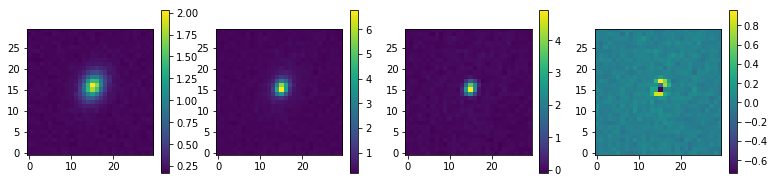

Now running blukn
emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 1
      x_fit             y_fit             flux_fit           flux_unc     
                                           ph / s             ph / s      
----------------- ------------------ ------------------ ------------------
15.13744513629369 15.667089473677793 13.192488238853398 0.7251241124178984


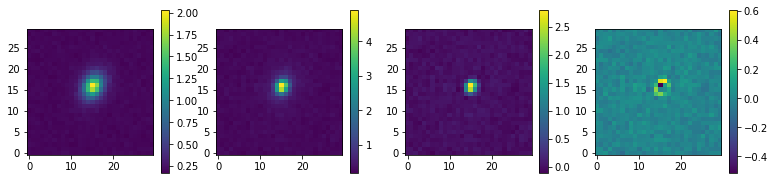

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 2
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.145161107890432 15.684628320246244 13.529578509341599 0.7181872043918066


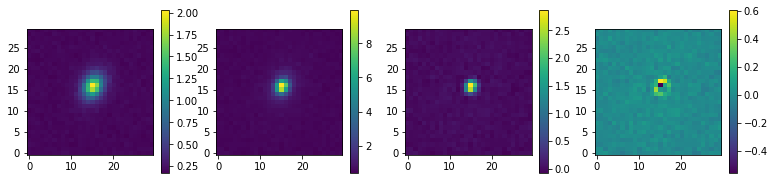

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 3
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.146185856935633 15.680910744675009 13.577003587522467 0.6962500425888813


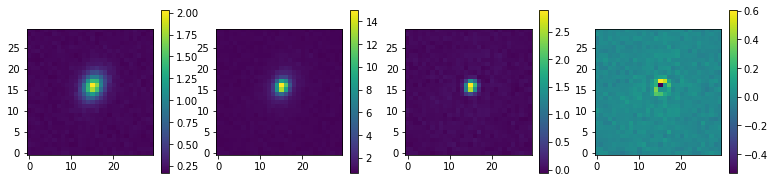

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 4
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.134223770670879 15.673334018094359 13.401544328822176 0.6748204950369513


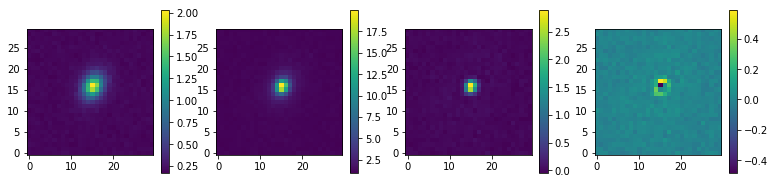

Photometry failed!
emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 5
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ----------------- ------------------ ------------------
15.143716444464447 15.67680416884725 13.486029072975587 0.6603123466659435


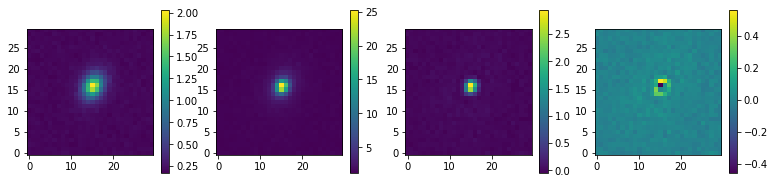

76 89.08 Mpc blukn 6
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.144507907281735 15.678720923808264 13.400183240333936 0.6633370744967325


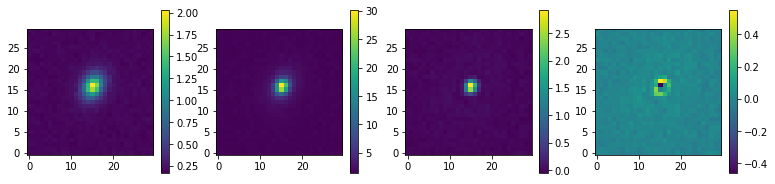

Now running shock
579 118.01 Mpc shock 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.708321617839548 14.755686233917524 6.7354605429493635  0.1558899810073498
 13.05054666369563  20.24345373562909  6.188962048674793 0.24883590830937302


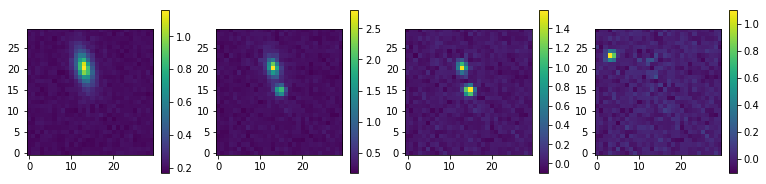

Now running blukn
579 118.01 Mpc blukn 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.803544085981978 14.922611285541501 0.8160478620016421 0.09507186745134623
 13.04913979113225  20.09966597473816  5.605418464108951 0.28313205143669523


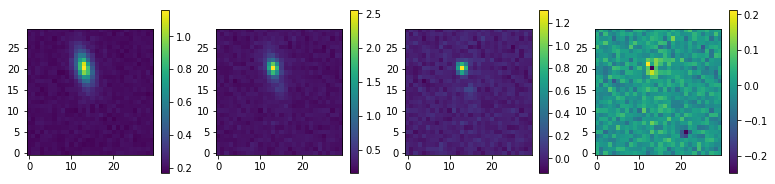

Now running shock
68 66.24 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.749223248931482 14.716452558603008 19.18581519899876 0.28437725039466716


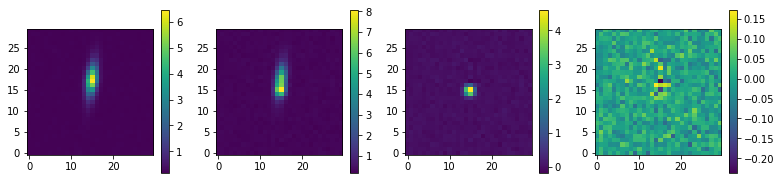

Now running blukn
68 66.24 Mpc blukn 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.789076809380429 14.714963885704977 2.7434161171144322 0.2025302009313846


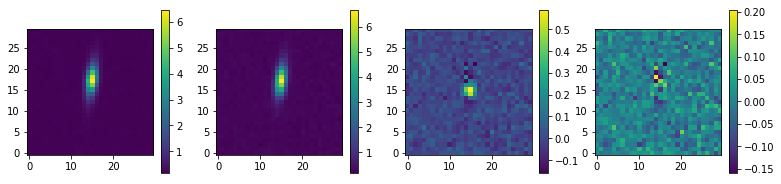

Now running shock
31 121.0 Mpc shock 1
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
14.70879159662655 14.676231792844419 6.045410862784979 0.2563620207155036


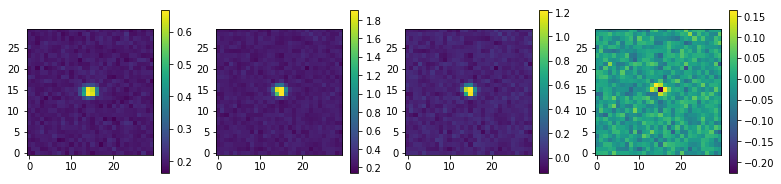

Now running blukn
31 121.0 Mpc blukn 1
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
14.43089002156162 14.519599570251833 0.6739452822404323 0.09626474926951521


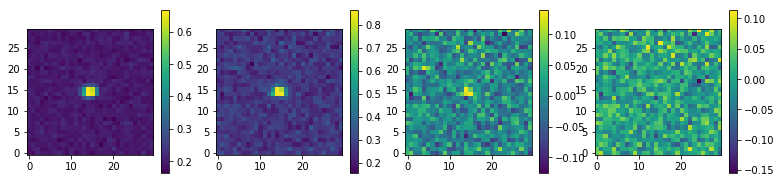

Now running shock
Now running blukn
Now running shock
434 134.06 Mpc shock 1
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
15.672954436812754 15.401868627772611 8.038166119888777 1.0111847687341204


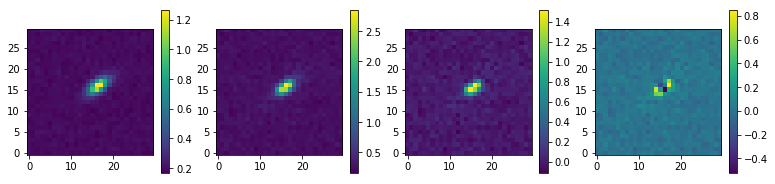

Now running blukn
emgw5_40min_blukn blukn 134.06 Mpc False Positive
434 134.06 Mpc blukn 1
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
16.33222249420274 15.828682250825679 6.643274241348994 0.2261240166234437


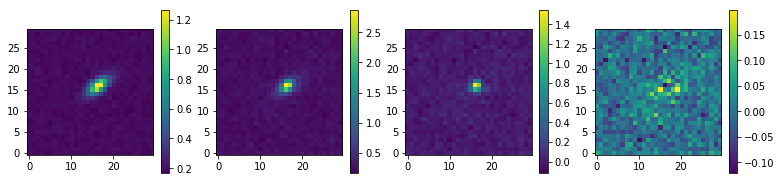

emgw5_40min_blukn blukn 134.06 Mpc False Positive
434 134.06 Mpc blukn 2
      x_fit             y_fit             flux_fit           flux_unc     
                                           ph / s             ph / s      
----------------- ------------------ ----------------- -------------------
16.34979884997151 15.840157058982372 6.291530432953476 0.25282971810618016


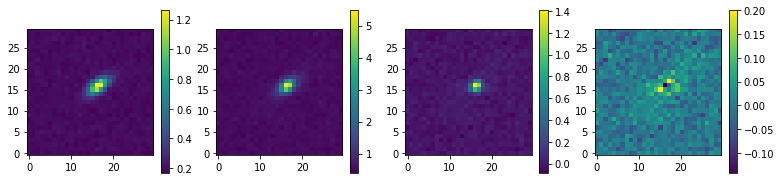

emgw5_40min_blukn blukn 134.06 Mpc False Positive
434 134.06 Mpc blukn 3
      x_fit             y_fit             flux_fit           flux_unc     
                                           ph / s             ph / s      
----------------- ------------------ ----------------- -------------------
16.34418752340195 15.781577168709509 6.152398652563714 0.19871693306500468


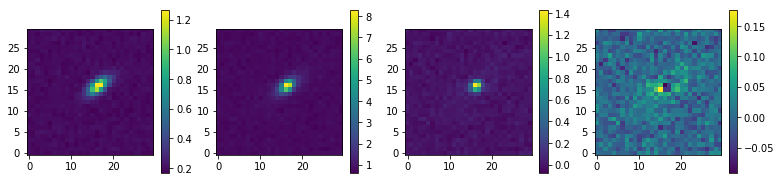

emgw5_40min_blukn blukn 134.06 Mpc False Positive
434 134.06 Mpc blukn 4
      x_fit             y_fit            flux_fit           flux_unc     
                                          ph / s             ph / s      
------------------ ---------------- ----------------- -------------------
16.371412674114765 15.8541460938636 6.268608642447712 0.23493467419484773


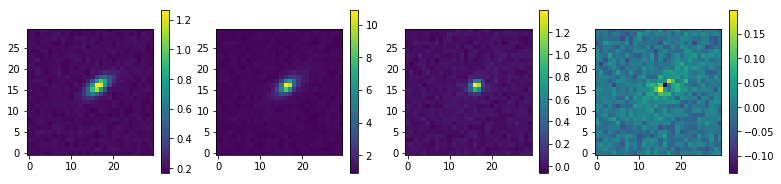

emgw5_40min_blukn blukn 134.06 Mpc False Positive
434 134.06 Mpc blukn 5
     x_fit             y_fit             flux_fit            flux_unc     
                                          ph / s              ph / s      
---------------- ------------------ ------------------ -------------------
16.3694916169799 15.857457595661185 6.3015553651487055 0.24081501268607008


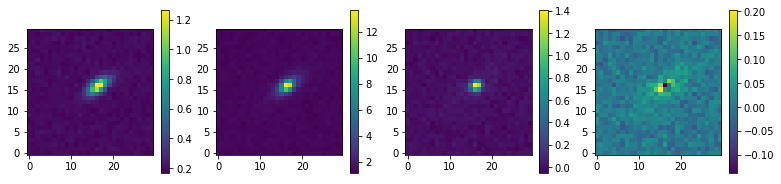

434 134.06 Mpc blukn 6
      x_fit             y_fit            flux_fit           flux_unc     
                                          ph / s             ph / s      
----------------- ------------------ ---------------- -------------------
16.36672287786975 15.856399970601325 6.27852225421649 0.24831098568731652


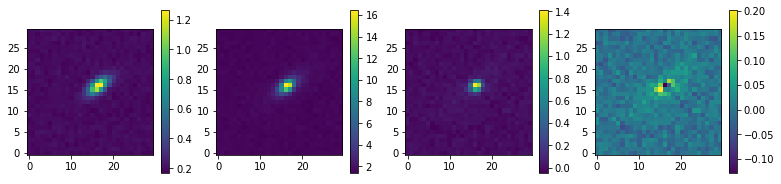

Now running shock
422 157.3 Mpc shock 1
      x_fit              y_fit             flux_fit          flux_unc    
                                            ph / s            ph / s     
------------------ ------------------ ----------------- -----------------
15.026999979642776 14.853827868159625 2.523114292125411 0.354591444154636


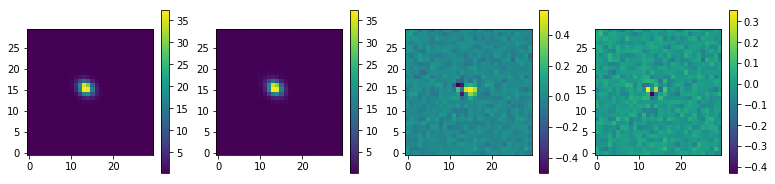

Now running blukn
Now running shock
17 132.56 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.705169678643344 14.748399178479978 4.699278962829652 0.17377348642615473


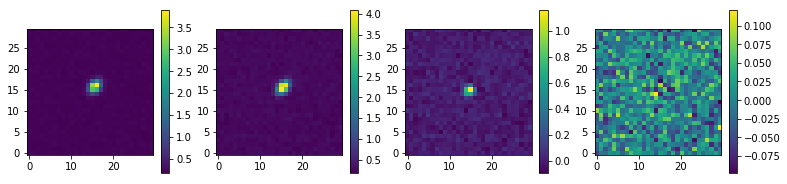

Now running blukn
17 132.56 Mpc blukn 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.817721433710362 14.740987252110402 0.8418360685676777 0.15810613628351597


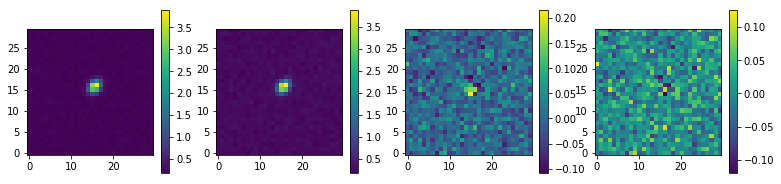

Now running shock
217 142.9 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.674090860238248 14.745271707177732 4.393388478553124 0.39820204844142026


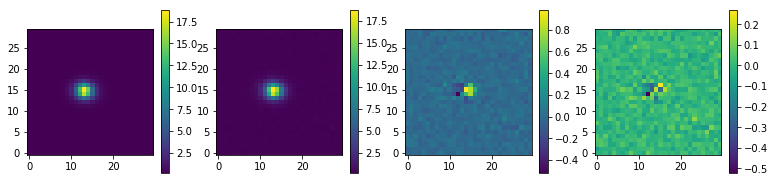

Now running blukn
Now running shock
284 176.56 Mpc shock 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.739544414574349 14.894913274682684 2.6704721282382935 0.14774665651057572


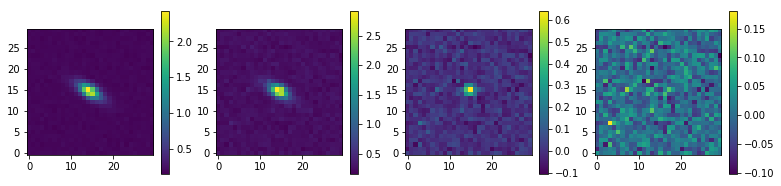

Now running blukn
emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 8
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ----------------- ------------------- -------------------
14.802053388033327 14.77719862839776 0.48201565304587335 0.07543390092342121


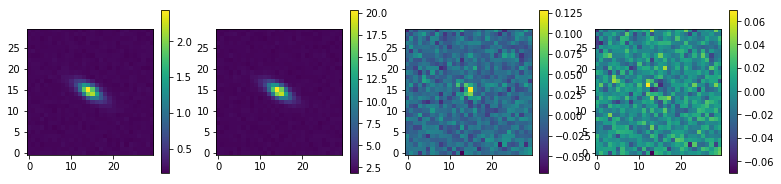

284 176.56 Mpc blukn 8
(inverse)
      x_fit              y_fit              flux_fit           flux_unc     
                                             ph / s             ph / s      
------------------ ------------------ ------------------- ------------------
14.937136412661314 14.754513155772063 -0.5146298171999997 0.0903474385466445


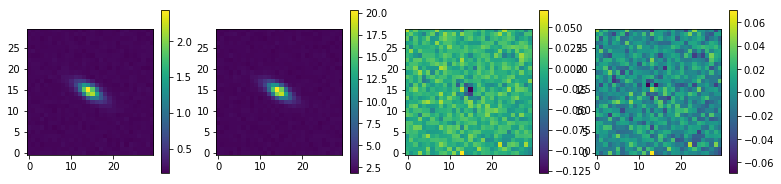

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 9
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ----------------- ----------------- -------------------
14.842011834480406 14.86431664374239 0.496879631836554 0.07352453191046252


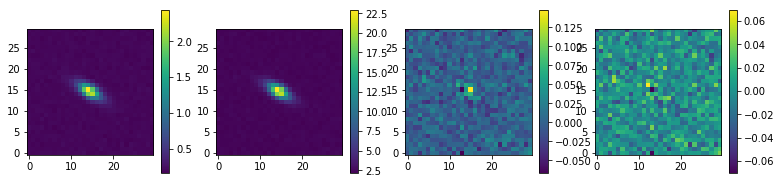

284 176.56 Mpc blukn 9
(inverse)
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
14.987204107503695 14.844741999359504 -0.5355872686756306 0.09287042458792846


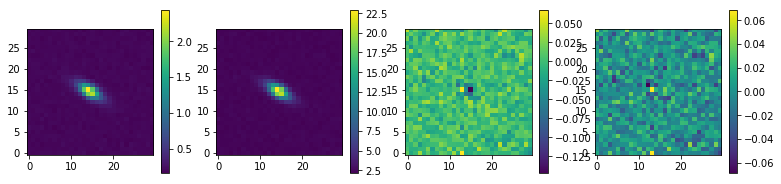

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 10
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
14.806250926705026 14.860802355761134 0.48002421700648024 0.07523730327301527


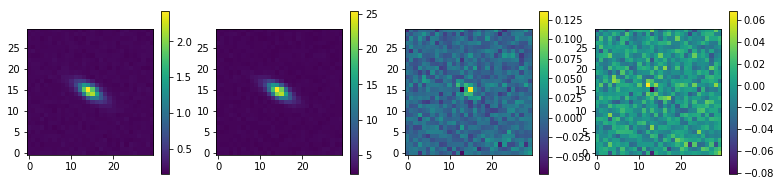

284 176.56 Mpc blukn 10
(inverse)
      x_fit             y_fit              flux_fit            flux_unc     
                                            ph / s              ph / s      
----------------- ------------------ ------------------- -------------------
14.88756273058241 14.852738240555231 -0.4995248812527718 0.08931742557206258


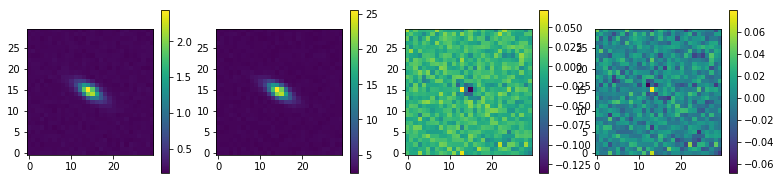

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 11
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.797563498921798 14.772542142072076 0.4716572464267049 0.07257641284177972


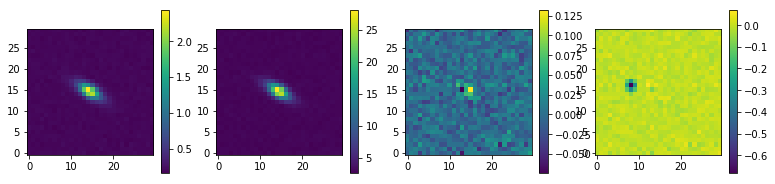

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 13
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.811492291953716 14.763027226244928 0.5597909111509899 0.04931122759312927


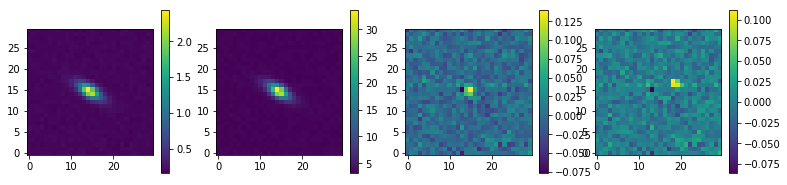

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 14
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.810941474273024 14.733716193911945 0.580952030099046 0.06455572723312542


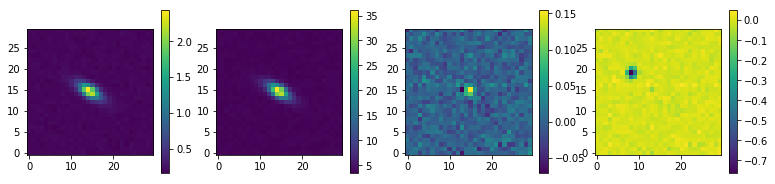

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 15
      x_fit             y_fit             flux_fit           flux_unc     
                                           ph / s             ph / s      
----------------- ------------------ ----------------- -------------------
14.82307966435321 14.713983149200454 0.585478438871629 0.06856132962063816


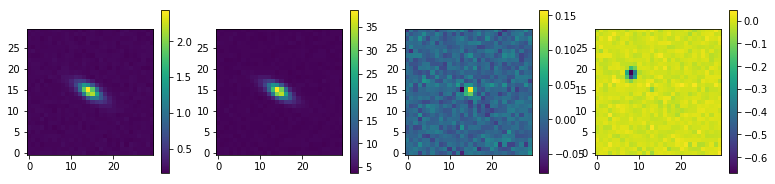

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 16
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
14.80744705605062 14.741556008352415 0.5826386559372885 0.06595641547786185


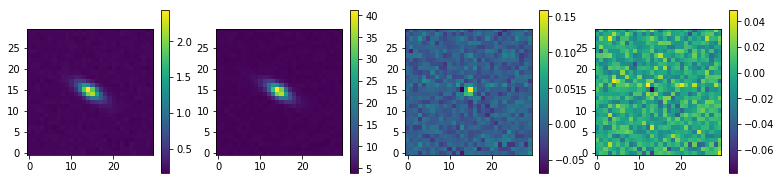

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 17
      x_fit              y_fit             flux_fit            flux_unc      
                                            ph / s              ph / s       
------------------ ------------------ ------------------ --------------------
14.804290100769004 14.757878496239156 0.5742436820989568 0.057491843500356014


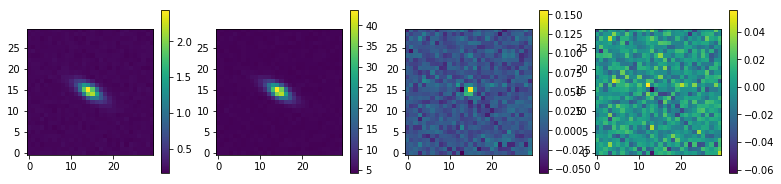

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 18
      x_fit             y_fit           flux_fit            flux_unc      
                                         ph / s              ph / s       
------------------ --------------- ------------------ --------------------
14.792048294188632 14.756811472914 0.5518273231685368 0.056974803051723984


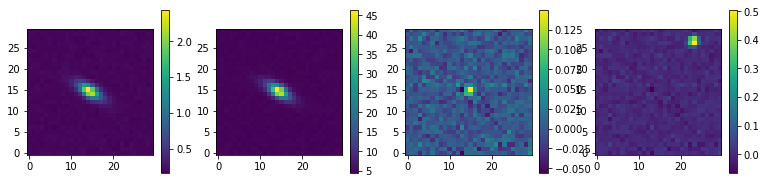

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 19
      x_fit              y_fit        ...        flux_unc       
                                      ...         ph / s        
------------------ ------------------ ... ----------------------
11.824433025056225 13.488550621905022 ...  8.514194841968345e-06
 14.80712357859003 14.754281777878862 ...  2.112823427647542e-06
 10.07189440747977 13.569247205317964 ... 1.3361803944759651e-05


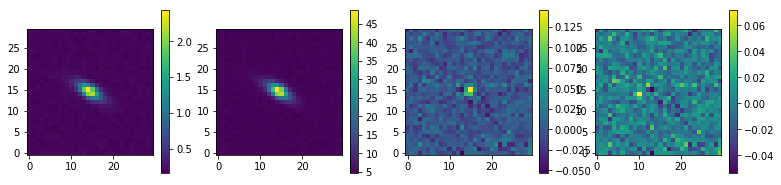

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 20
      x_fit              y_fit             flux_fit             flux_unc       
                                            ph / s               ph / s        
------------------ ------------------ ------------------ ----------------------
17.724612480027023 11.553194829379512 0.9602202823104832 -7.152656210374086e-10
14.795263769500897  14.75617667803923 0.5244252230245502   6.79841759242128e-07
11.323674903084523  19.64361584812324 -0.938320760642465 -8.280575760546277e-07


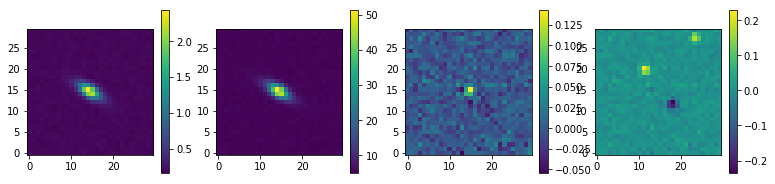

emgw9_40min_blukn blukn 176.56 Mpc False Positive
284 176.56 Mpc blukn 21
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.798705734275643 14.805557163114607 0.5400356107417698 0.04741289290660061


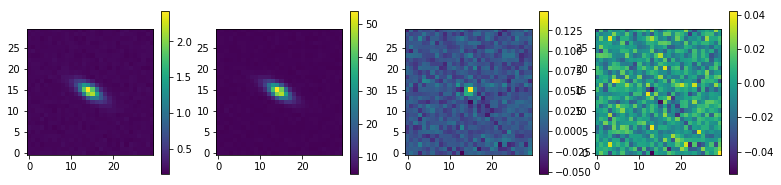

Now running shock
272 165.32 Mpc shock 1
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
14.710252084452424 14.726852121876362 2.981187031741109 0.1306145187206271


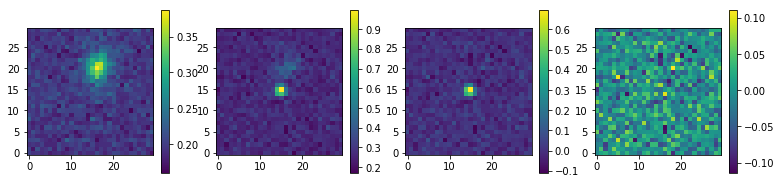

Now running blukn
272 165.32 Mpc blukn 4
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
14.618402117221741 15.107010799309146 0.32695045099934733 0.05726303366007697


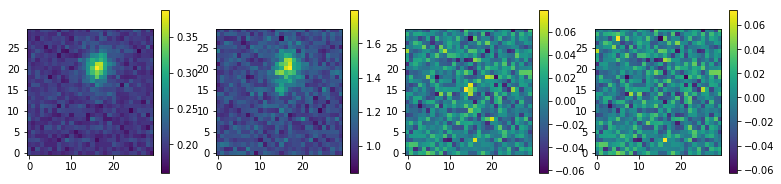

Now running shock
175 126.79 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.782253346154643 14.739840132061108 5.730610256155616 0.14400005030086208


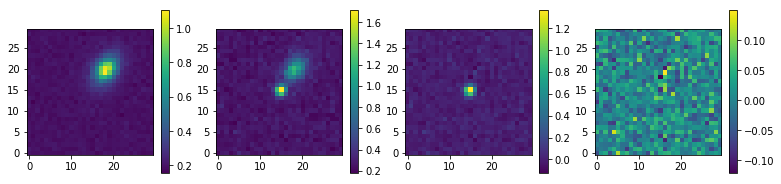

Now running blukn
175 126.79 Mpc blukn 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.702235994863377 14.738251151291696 0.5903996893234374 0.11257447007070714


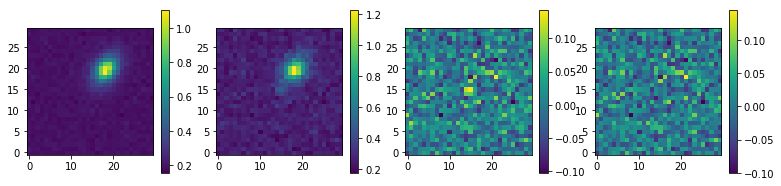

Now running shock
332 171.0 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.853014189066952 14.791691318564673 3.0918349568072694 0.1357190334250893


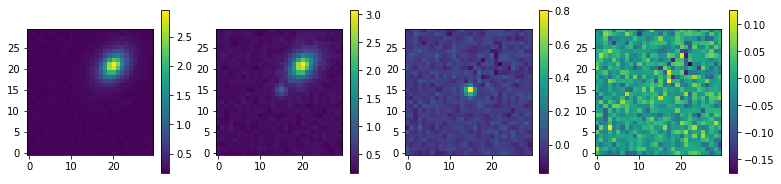

Now running blukn
332 171.0 Mpc blukn 3
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
15.14491479984025 14.677976184914689 0.2947672295294833 0.05756205068582039


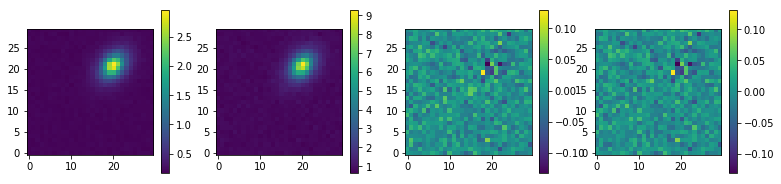

Now running shock
348 172.01 Mpc shock 1
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.719495741521818 14.688402011711357 3.2025474875095825 0.34891616217525934
15.775071156777477 17.968009275942464 2.7852966825477665 0.19349436119541794


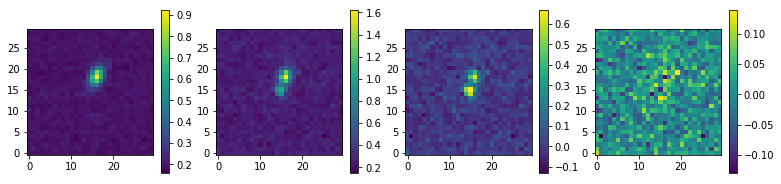

Now running blukn
Now running shock
18 103.83 Mpc shock 1
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ------------------ ---------------- -------------------
14.710849876667439 14.782069183987202 7.78342076242505 0.27432562082876316


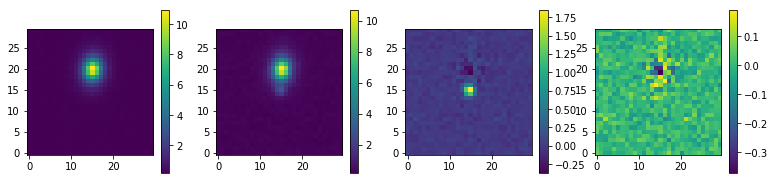

Now running blukn
18 103.83 Mpc blukn 1
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
 4.059321734988523 3.383598345929714  7.519069678838845                 0.0
14.415234629757633 14.94281853823165 1.3460508209308768 0.17722376642681625


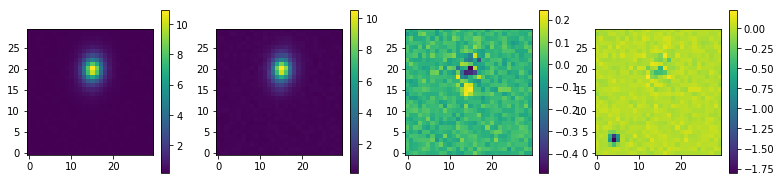

Now running shock
Now running blukn
Now running shock
Now running blukn
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
emgw16_40min_blukn blukn 255.66 Mpc False Positive
Now running shock
emgw17_40min_shock shock 207.03 Mpc False Positive
Now running blukn
emgw17_40min_blukn blukn 207.03 Mpc False Positive
emgw17_40min_blukn blukn 207.03 Mpc False Positive
emgw17_40min_blukn blukn 207.03 Mpc False Positive
emgw17_40min_blukn blukn 207.03 Mpc False Positive
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Photometry failed!
Now running shock
emgw19_40min_shock shock 286.85 Mpc False Positive
Now running blukn
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
emgw19_40min_blukn blukn 286.85 Mpc False Positive
Now running shock
Now running blukn
emgw20_40min_blukn blukn 83.51 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw23_40min_blukn blukn 270.46 Mpc False Positive
emgw23_40min_blukn blukn 270.46 Mpc False Positive
emgw23_40min_blukn blukn 270.46 Mpc F

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
emgw25_40min_blukn blukn 114.17 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw27_40min_blukn blukn 172.42 Mpc False Positive
emgw27_40min_blukn blukn 172.42 Mpc False Positive
emgw27_40min_blukn blukn 172.42 Mpc False Positive
emgw27_40min_blukn blukn 172.42 Mpc False Positive
emgw27_40min_blukn blukn 172.42 Mpc False Positive
Now running shock
Now running blukn
Now running shock
emgw29_40min_shock shock 159.12 Mpc False Positive
Now running blukn
emgw29_40min_blukn blukn 159.12 Mpc False Positive
emgw29_40min_blukn blukn 159.12 Mpc False Positive
emgw29_40min_blukn blukn 159.12 Mpc False Positive
emgw29_40min_blukn blukn 159.12 Mpc Fals

emgw40_40min_blukn blukn 251.26 Mpc False Positive
emgw40_40min_blukn blukn 251.26 Mpc False Positive
emgw40_40min_blukn blukn 251.26 Mpc False Positive
emgw40_40min_blukn blukn 251.26 Mpc False Positive
emgw40_40min_blukn blukn 251.26 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
emgw42_40min_blukn blukn 292.76 Mpc False Positive
Now running shock
Now running blukn
emgw43_40min_blukn blukn 

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
emgw46_40min_blukn blukn 136.07 Mpc False Positive
Now running shock
Now running blukn
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
emgw47_40min_blukn blukn 85.47 Mpc False Positive
em

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw51_40min_shock shock 274.73 Mpc False Positive
Now running blukn
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
emgw51_40min_blukn blukn 274.73 Mpc False Positive
Now running shock
Now running blukn
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40min_blukn blukn 258.62 Mpc False Positive
emgw52_40m

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
emgw70_40min_blukn blukn 268.91 Mpc False Positive
Now running shock
Now running blukn
emgw71_40min_blukn blukn 358.34 Mpc False Positive
emgw71_40min_blukn blukn 358.34 Mpc False Positive
emgw71_40min_blukn blukn 358.34 Mpc False Positive
emgw71_40min_blukn blukn 358.34 Mpc False Positive
emgw71_40min_blukn blukn 358.34 Mpc False Positive
emgw71_40m

emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_shock shock 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_shock shock 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_shock shock 196.05 Mpc False Positive
Photometry failed!
Now running blukn
emgw82_40min_blukn blukn 196.05 Mpc False Positive
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!


emgw82_40min_blukn blukn 196.05 Mpc False Positive
Photometry failed!
emgw82_40min_blukn blukn 196.05 Mpc False Positive


Photometry failed!
Now running shock
Now running blukn
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
emgw83_40min_blukn blukn 182.76 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


Photometry failed!
Now running blukn


Photometry failed!
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw90_40min_blukn blukn 450.96 Mpc False Positive
Now running shock
emgw91_40min_shock shock 234.18 Mpc False Positive
Now running blukn
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
emgw91_40min_blukn blukn 234.18 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
emgw94_40min_shock shock 422.49 Mpc False Positive
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw96_40min_shock shock 287.79 Mpc False P

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw101_40min_shock shock 310.58 Mpc False Positive
emgw101_40min_shock shock 310.58 Mpc False Positive
Now running blukn
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
emgw101_40min_blukn blukn 310.58 Mpc False Positive
Now running shock
Now runnin

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
emgw109_40min_blukn blukn 438.23 Mpc False Positive
Now running shock
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 493.66 Mpc False Positive
emgw110_40min_shock shock 

Photometry failed!


Photometry failed!


Photometry failed!
Photometry failed!


Photometry failed!


Photometry failed!
Now running blukn


Photometry failed!
Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!
Now running shock
emgw115_40min_shock shock 395.82 Mpc False Positive
Now running blukn
emgw115_40min_blukn blukn 395.82 Mpc False Positive
emgw115_40min_blukn blukn 395.82 Mpc False Positive
emgw115_40min_blukn blukn 395.82 Mpc False Positive
emgw115_40min_blukn blukn 395.82 Mpc False Positive
emgw115_40min_blukn blukn 395.82 Mpc False Positive
Now running shock
Now running blukn
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
emgw116_40min_blukn blukn 168.36 Mpc False Positive
Now running shock
Now running blukn
Now running shock
emgw118_40min_shock shock 410.92 Mpc False Positive
Now running blukn
emgw118_40min_blukn blukn 410.92 Mpc False Positive
emgw118_40min_blukn blukn 410.92 Mpc False Positive
emgw1

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


emgw125_40min_blukn blukn 168.42 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
emgw128_40min_shock shock 355.77 Mpc False Positive
Now running blukn
Now running shock
Now running blukn
Now running shock
Now ru

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
emgw153_40min_blukn blukn 222.23 Mpc False Positive
Now running shock
Now running blukn
emgw154_40min_blukn blukn 364.1 Mpc False Positive
emgw154_40min_blukn blukn 364.1 Mpc False Positive
emgw154_40min_blukn blukn 364.1 Mpc False Positive
emgw154_40min_blukn blukn 364.1 Mpc False Positive
emgw154_40min_blukn blukn 364.1 Mpc False Positi

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
emgw161_40min_blukn blukn 267.55 Mpc False Positive
Now running shock
Now running blukn
emgw162_40min_blukn blukn 181.23 Mpc False Positive
emgw162_40min_blukn blukn 181.23 Mpc False Positive
emgw162_40min_blukn blukn 181.23 Mpc False Positive
emgw162_40min_blukn blukn 181.23 Mpc False P

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


emgw170_40min_blukn blukn 190.44 Mpc False Positive
emgw170_40min_blukn blukn 190.44 Mpc False Positive
emgw170_40min_blukn blukn 190.44 Mpc False Positive
emgw170_40min_blukn blukn 190.44 Mpc False Positive
emgw170_40min_blukn blukn 190.44 Mpc False Positive
Now running shock
Now running blukn
Now running shock
emgw172_40min_shock shock 290.82 Mpc False Positive
Now running blukn
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
emgw172_40min_blukn blukn 290.82 Mpc False Positive
Now running shock
emgw173_40min_shock shock 471.25 Mpc False Positive
Now running blukn
emgw173_40min_blukn blukn 471.25 Mpc False Positive
emgw173_

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw199_40min_shock shock 432.05 Mpc False Positive
Now running blukn
emgw199_40min_blukn blukn 432.05 Mpc False Positive
emgw199_40min_blukn blukn 432.05 Mpc False Positive
emgw199_40min_blukn blukn 432.05 Mpc False Positive
Now running shock
Now running blukn
emgw200_40min_blukn blukn 174.81 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw213_40min_blukn blukn 117.96 Mpc False Positive
emgw213_40min_blukn blukn 117.96 Mpc False Positive
emgw213_40min_blukn blukn 117.96 Mpc False Positive
Now running shock
Now running blukn
Now running shock
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.87 Mpc False Positive
emgw215_40min_shock shock 424.

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


emgw222_40min_blukn blukn 272.34 Mpc False Positive
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw224_40min_shock shock 503.16 Mpc False Positive
Now running blukn
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
emgw224_40min_blukn blukn 503.16 Mpc False Positive
Now running shock
emgw225_40min_shock shock 388.89 Mpc False Positive
emgw225_40min_shock shock 388.89 Mpc False Positive
emgw225_40min_shock shock 388.89 Mpc False Positive
emgw225_40min_shock shock 388.89 Mpc False Positive
emgw225_40min_shock shock 388.89 Mpc False Positive
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now 

Now running shock
Now running blukn
Now running shock
Now running blukn
emgw271_40min_blukn blukn 280.2 Mpc False Positive
emgw271_40min_blukn blukn 280.2 Mpc False Positive
emgw271_40min_blukn blukn 280.2 Mpc False Positive
emgw271_40min_blukn blukn 280.2 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw277_40min_blukn blukn 155.9 Mpc False Positive
emgw277_40min_blukn blukn 155.9 Mpc False Positive
Now running shock
Now running blukn
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw278_40min_blukn blukn 238.67 Mpc False Positive
emgw27

Photometry failed!
Photometry failed!
Now running blukn


Photometry failed!
Photometry failed!


Photometry failed!
Now running shock
emgw292_40min_shock shock 405.34 Mpc False Positive
emgw292_40min_shock shock 405.34 Mpc False Positive
emgw292_40min_shock shock 405.34 Mpc False Positive
emgw292_40min_shock shock 405.34 Mpc False Positive
Now running blukn
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
emgw292_40min_blukn blukn 405.34 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw300_40min_shock shock 306.98 Mpc False Positive
emgw300_40min_shock shock 306.98 Mpc False Positive
Now running blukn
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
emgw300_40min_blukn blukn 306.98 Mpc False Positive
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
emgw303_40min_blukn blukn 170.82 Mpc False Positive
emgw303_40min_blukn blukn 170.82 Mpc False Positive
emgw303_40min_blukn blukn 170.82 Mpc False Positive
emgw303_40min_blukn blukn 170.82 Mpc False Positive
emgw303_40min_blukn blukn 170.82 Mpc False Positive
emgw303_40min_blukn blukn 170.82 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw307_40min_shock shock 370.04 Mpc False Positive
Now running blukn
emgw307_40min_blukn blukn 370.04 Mpc False Positive
emgw307_40min_blukn blukn 370.04 Mpc False Positive
emgw307_40min_blukn blukn 370.04 Mpc False Positive
emgw307_40min_blukn blukn 370.04 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw310_40min_shock shock 327.36 Mpc False Positive
Now running blukn
emgw310_40min_blukn blukn 327.36 Mpc False Positive
emgw310_40min_bluk

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
emgw321_40min_shock shock 371.02 Mpc False Positive
Now running blukn
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
emgw321_40min_blukn blukn 371.02 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


Photometry failed!
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw328_40min_blukn blukn 345.08 Mpc False Positive
emgw328_40min_blukn blukn 345.08 Mpc False Positive
emgw328_40min_blukn blukn 345.08 Mpc False Positive
emgw328_40min_blukn blukn 345.08 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw337_40min_blukn blukn 426.99 Mpc False Positive
emgw337_40min_blukn blukn 426.99 Mpc False Positive
Now running shock
emgw338_40min_shock shock 601.06 Mpc False Positive
emgw338_40min_shock shock 601.06 Mpc False Positive
emgw338_40min_shock shock 601.06 Mpc False Positive
Now running blukn
Now running shock
Now runni

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
emgw350_40min_shock shock 265.06 Mpc False Positive
Now running blukn
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
Photometry failed!


emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
emgw350_40min_blukn blukn 265.06 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw357_40min_shock shock 265.12 Mpc False Positive
emgw357_40min_shock shock 265.12 Mpc False Positive
emgw357_40min_shock shock 265.12 Mpc False Positive
Now running blukn
emgw357_40min_blukn blukn 265.12 Mpc False Positive
emgw357_40min_blukn blukn 265.12 Mpc False Positive
emgw357_40min_blukn blukn 265.12 Mpc False Positive
emgw357_40min_blukn blukn 265.12 Mpc False Positive
Photometry failed!


emgw357_40min_blukn blukn 265.12 Mpc False Positive


Photometry failed!
emgw357_40min_blukn blukn 265.12 Mpc False Positive
emgw357_40min_blukn blukn 265.12 Mpc False Positive
Photometry failed!
emgw357_40min_blukn blukn 265.12 Mpc False Positive


Now running shock
Now running blukn
Now running shock
Now running blukn
emgw359_40min_blukn blukn 182.82 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw366_40min_shock shock 298.79 Mpc False Positive
emgw366_40min_shock shock 298.79 Mpc False Positive
Now running blukn
emgw366_40min_blukn blukn 298.79 Mpc False Positive
emgw366_40min_blukn blukn 298.79 Mpc False Positive
emgw366_40min_blukn blukn 298.79 Mpc False Positive
emgw366_40min_blukn blukn 298.79 Mpc False Positive
emgw366_40min_blukn blukn 298.79 Mpc False Positive
emgw366_40min_blukn blukn 298.79 Mpc False Positive
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now runnin

In [17]:
# For each event, loop through exposures until a source is detected, insert number into results table
results = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                dtype=('i2', 'i2', 'f8', 'i4', 'i4', 'S5', 'i2', 'i1'))

# Loop through the light curves for the events
for i, e in enumerate(emgw):
    
    distance = e['distance']
    
    # Generate reference image from galaxy stuff in sim_details
    gal = sim_details[sim_details['id'] == np.int(e['id'])]
    
    rad, theta, pos = gal['rad'], gal['theta'], gal['pos']
    rad_pix = rad / pixel_size_init
    d = pos * rad / pixel_size_init
    x_0 = d * np.cos(theta) 
    y_0 = d * np.sin(theta)
            
    gal_params = {'magnitude': gal['mag'], 'r_eff': rad_pix.value, 'n': gal['n'], 'theta': theta, \
                   'ellip': gal['ellip'], 'x_0': x_0.value, 'y_0': y_0.value}
    
    # Generate combined reference image for this galaxy/source setup
    nexp = 7
    ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                 gal_type='custom', gal_params=gal_params, sky_rate=bgd_band1, n_exp=nexp)
    ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                 gal_type='custom', gal_params=gal_params, sky_rate=bgd_band2, n_exp=nexp)
    total_ref_rate = (ref_image1 + ref_image2) / (exposure * nexp)
    ref_bkg, ref_bkg_rms_median = estimate_background(total_ref_rate, method='1D', sigma=2)
    ref_bkgsub = total_ref_rate - ref_bkg
    
    # Loop through different models
    for mod in ['shock','blukn']:
        
        print('Now running '+mod)

        # Grab the lightcurve files we need 
        name = 'emgw{}_40min_{}'.format(i,mod)
        table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')
        
        # Loop through images, summing until we get a detection
        img_sum = np.zeros(frame) * u.ph / u.s
        num_exp, fluence_sum, detect = 0, 0, 0
        start_time, det_time = 0, 0
        for row in table:

            if row.index % e['pointings'] == 0:
                # Only add exposures that are a multiple of the number of pointings
                num_exp += 1
                false = 0
                
                # Add both bands and add them to total summed image
                img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

                # Convert to average rate
                img_rate = img_sum / num_exp

                # Estimate background
                img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
                img_bkgsub = img_rate - img_bkg

                # Make difference image
                diff_image = calculate_diff_image(img_rate, img_bkgsub, total_ref_rate, ref_bkgsub)
                
                # Run Find and then DAOPhot on img_sum (DAOPhot by default only returns srcs with snr >= 5)
                fluence_sum += row['fluence_D1'] + row['fluence_D2']
                
                result_tbl, found, false_pos, frac_diff, residual = find_check(diff_image,psf_fwhm_pix.value,
                                                                               fluence_sum)
                
                if false_pos == 1: 
                    print(name, mod, distance, 'False Positive')
                    false = 1
                        
                # Source successfully found! 
                if found == 1:
                    # Record number of exposures it took, break loop
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, false))
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp)

                        print(result_tbl['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    # Still continue if a false positive, we just want to record it
                    if false == 0:
                        detect = 1
                        break
                
                # We don't detect it, so flip the difference image and look for negative changes
                inv = -diff_image

                inv_tbl, found, false_pos, frac_diff, residual = find_check(inv,psf_fwhm_pix.value,-fluence_sum)
                
                if false_pos == 1: 
                    print(name, mod, distance, 'False Positive, inverse')
                    false = 1
                        
                # Source successfully found! 
                if found == 1:
                    # Record number of exposures it took, break loop
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, false))
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp)

                        print('(inverse)')
                        print(inv_tbl['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(inv.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    if false == 0:
                        detect = 1
                        break
            
        # If source hasn't been detected record this
        if detect == 0:
            results.add_row((e['id'], e['pointings'], distance, start_time, -1, mod, -1, 0))
                
print(results)

# Write results to output
results.write('../astroduet/data/emgw_40min_results_ground.fits', format='fits', overwrite=True)

In [33]:
def collabel(rects1, rects2, labels, xpos='center'):
    """
    Attach a text label above each bar in *rects*

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for i, rect1 in enumerate(rects1):
        height1 = rect1.get_height()
        height2 = rects2[i].get_height()
        height = np.maximum(height1,height2)
        plt.annotate('{}'.format(labels[i]),
                     xy=(rect1.get_x() + rect1.get_width() / 2, height),
                     xytext=(offset[xpos]*2, 2),  # use 2 points offset
                     textcoords="offset points",  # in both directions
                     ha=ha[xpos], va='bottom')

def plot_all_the_things(shock_res_strict,shock_res_lax,blukn_res_strict,blukn_res_lax):
    # What percentage were detected?
    shock_pc_strict = len(shock_res_strict[shock_res_strict['num_exp'] > -1]) / len(shock_res_strict) * 100
    blukn_pc_strict = len(blukn_res_strict[blukn_res_strict['num_exp'] > -1]) / len(blukn_res_strict) * 100

    print("Percentage detected (strict): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_strict,blukn_pc_strict))

    shock_pc_lax = len(shock_res_lax[shock_res_lax['num_exp'] > -1]) / len(shock_res_lax) * 100
    blukn_pc_lax = len(blukn_res_lax[blukn_res_lax['num_exp'] > -1]) / len(blukn_res_lax) * 100

    print("Percentage detected (lax): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_lax,blukn_pc_lax))

    # Plot distance vs num_exp and vs time
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Number of exposures required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['num_exp'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['num_exp'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Number of exposures required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['num_exp'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['num_exp'],label='shock')
    plt.legend()
    plt.show()

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Time required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['det_time'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['det_time'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Time required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['det_time'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['det_time'],label='shock')
    plt.legend()
    plt.show()

    # Detected by distance
    dists = np.arange(0,700,50)

    shock_res_binned, _ = np.histogram(shock_res_strict['distance'], bins=dists)
    shock_res_det_binned, _ = np.histogram(shock_res_strict[shock_res_strict['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_pc = np.nan_to_num(shock_res_det_binned / shock_res_binned * 100)

    blukn_res_binned, _ = np.histogram(blukn_res_strict['distance'], bins=dists)
    blukn_res_det_binned, _ = np.histogram(blukn_res_strict[blukn_res_strict['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_pc = np.nan_to_num(blukn_res_det_binned / blukn_res_binned * 100)

    shock_res_lax_binned, _ = np.histogram(shock_res_lax['distance'], bins=dists)
    shock_res_det_lax_binned, _ = np.histogram(shock_res_lax[shock_res_lax['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_lax_pc = np.nan_to_num(shock_res_det_lax_binned / shock_res_lax_binned * 100)

    blukn_res_lax_binned, _ = np.histogram(blukn_res_lax['distance'], bins=dists)
    blukn_res_det_lax_binned, _ = np.histogram(blukn_res_lax[blukn_res_lax['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_lax_pc = np.nan_to_num(blukn_res_det_lax_binned / blukn_res_lax_binned * 100)

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Number detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,80)
    plt.subplot(122)
    plt.title('Number detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,80)
    plt.show()

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Percentage detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.subplot(122)
    plt.title('Percentage detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.show()

    # Detected by number of pointings
    pointings_pl = np.arange(np.max(results['pointings']))+1

    shock_pointings = np.array([np.sum(shock_res_strict['pointings'] == p) for p in pointings_pl])
    shock_pointings_det = np.array([np.sum((shock_res_strict['pointings'] == p) & \
                                           (shock_res_strict['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_det_pc = np.nan_to_num(shock_pointings_det / shock_pointings * 100)

    blukn_pointings = np.array([np.sum(blukn_res_strict['pointings'] == p) for p in pointings_pl])
    blukn_pointings_det = np.array([np.sum((blukn_res_strict['pointings'] == p) & \
                                           (blukn_res_strict['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_det_pc = np.nan_to_num(blukn_pointings_det / blukn_pointings * 100)

    shock_pointings_lax = np.array([np.sum(shock_res_lax['pointings'] == p) for p in pointings_pl])
    shock_pointings_lax_det = np.array([np.sum((shock_res_lax['pointings'] == p) & \
                                           (shock_res_lax['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_lax_det_pc = np.nan_to_num(shock_pointings_lax_det / shock_pointings_lax * 100)

    blukn_pointings_lax = np.array([np.sum(blukn_res_lax['pointings'] == p) for p in pointings_pl])
    blukn_pointings_lax_det = np.array([np.sum((blukn_res_lax['pointings'] == p) & \
                                           (blukn_res_lax['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_lax_det_pc = np.nan_to_num(blukn_pointings_lax_det / blukn_pointings_lax * 100)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,180)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,180)
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,100)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,100)
    plt.legend()
    plt.show()

In [21]:
# Results for 40 mins

# Sort out results table
results_file = fits.open('../astroduet/data/emgw_40min_results_ground.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict_40min = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict_40min = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'i1'))
blukn_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax_40min.add_row(min_exp[0])
    else:
        shock_res_lax_40min.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax_40min.add_row(min_exp[0])
    else:
        blukn_res_lax_40min.add_row(rows_blukn[0])

RESULTS FOR 40 MIN START
For <4 pointings and distance <300 Mpc:
Shock events detected within...
2 hrs: 114/160
3 hrs: 152/160
4 hrs: 152/160
6 hrs: 152/160
Blukn events detected within...
2 hrs: 52/160
3 hrs: 86/160
4 hrs: 102/160
6 hrs: 116/160

 Overall results:
Percentage detected (strict): 83.52 % (shock), 35.01 % (blue kilonova)
Percentage detected (lax): 87.64 % (shock), 48.74 % (blue kilonova)


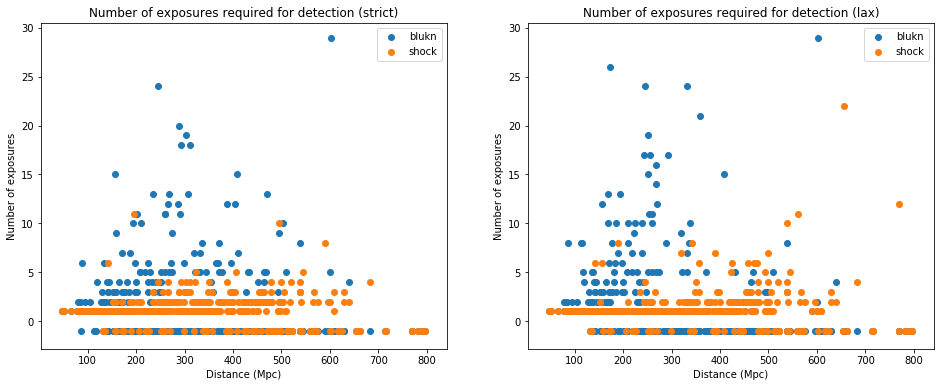

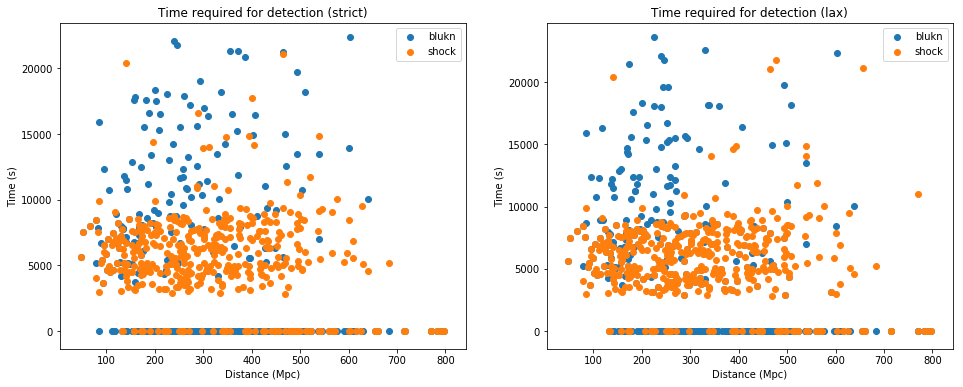

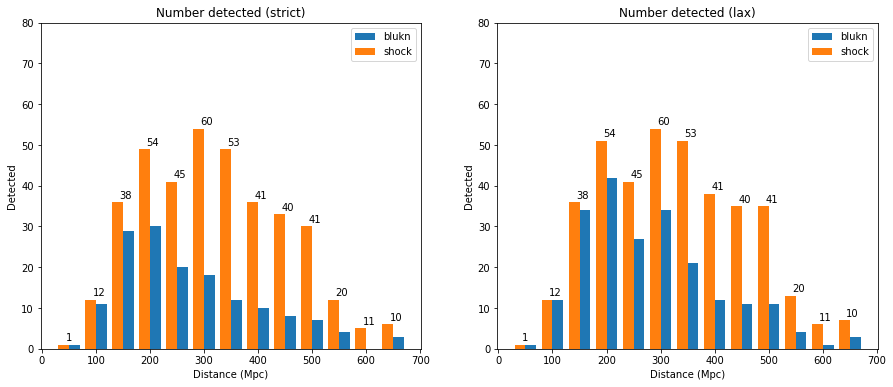

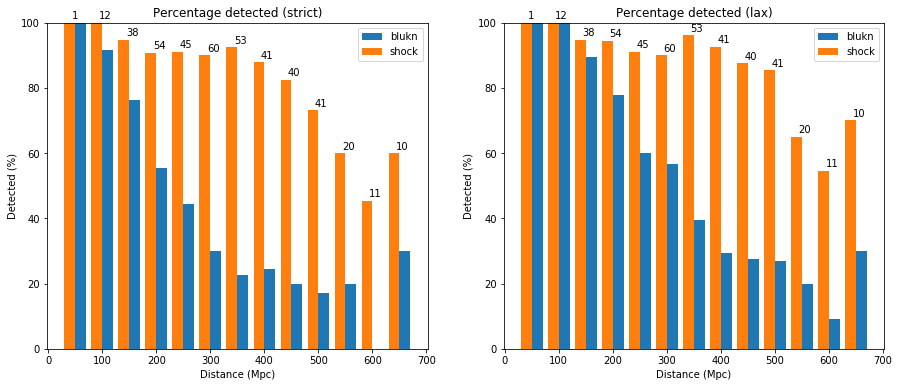

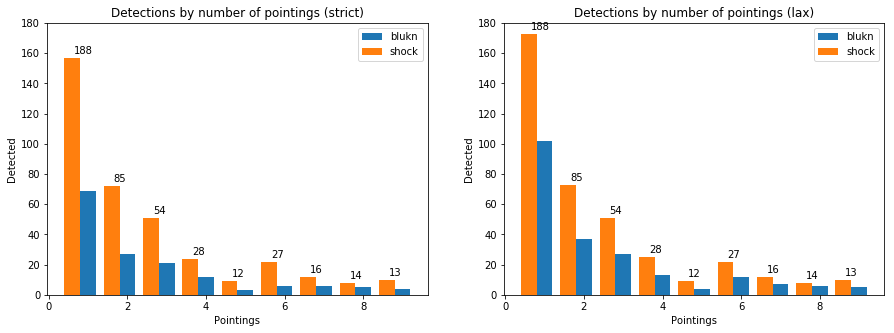

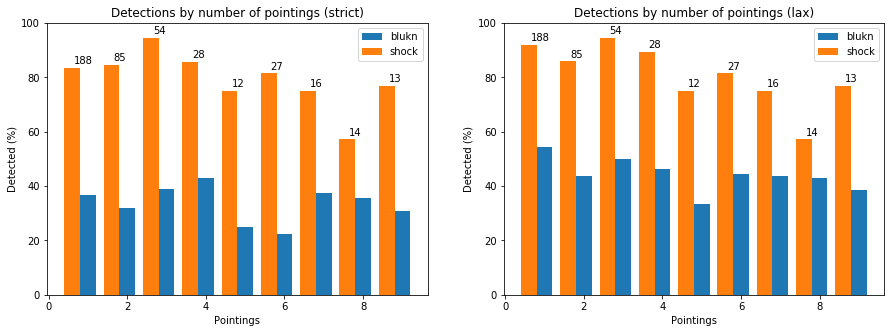

In [37]:
print('RESULTS FOR 40 MIN START')

srl = shock_res_lax_40min[(shock_res_lax_40min['pointings'] < 4) & (shock_res_lax_40min['distance'] < 300)]
brl = blukn_res_lax_40min[(blukn_res_lax_40min['pointings'] < 4) & (blukn_res_lax_40min['distance'] < 300)]

shock_time = srl['det_time'] - srl['start_time']
blukn_time = brl['det_time'] - brl['start_time']

print('For <4 pointings and distance <300 Mpc:')

print('Shock events detected within...')
print('2 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 7200)]), len(srl)))
print('3 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 10800)]), len(srl)))
print('4 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 14400)]), len(srl)))
print('6 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 21600)]), len(srl)))

print('Blukn events detected within...')
print('2 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 7200)]), len(brl)))
print('3 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 10800)]), len(brl)))
print('4 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 14400)]), len(brl)))
print('6 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 21600)]), len(brl)))

print('\n Overall results:')

plot_all_the_things(shock_res_strict_40min,shock_res_lax_40min,blukn_res_strict_40min,blukn_res_lax_40min)